#### Read binary files of an OE binary format session and extract channels by name
exports them to wav files for segmentation/clasification

In [2]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json
import h5py

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal, stats
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process


import xmltodict

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

2022-08-16 21:01:44,549 root         INFO     Running on pakhi


In [6]:
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import fileutil as fu
#from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp

from ceciestunepipe.pipeline import searchbout as sb

logger.info('all modules loaded')

2022-08-16 21:05:32,965 root         INFO     all modules loaded


In [19]:
! ls /mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/openephys/

2022-08-12_16-47-24


In [13]:
reload(et)

bird = 't_systest_22'
all_bird_sess = et.list_sessions(bird)
all_bird_sess

['2022-08-12']

In [14]:
sess_par = {'bird': bird,
           'sess': '2022-08-12',
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': None, # if there was a stimulus epoch, where the stimuli were coming from
           'mic_chan': 0, # where the microphone is in the wav_mic.npy array
           'pre_chan': 0} # where the pressure is in the wav_adc.npy array

In [71]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'], ephys_software='oe')
exp_struct['folders']['oe']

'/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/oe'

In [65]:
def oe_list_epochs(exp_struct):
    sess_path = os.path.join(exp_struct['folders']['oe'])
    epoch_list = [os.path.split(f.path)[-1] for f in os.scandir(sess_path) if f.is_dir()]
    return epoch_list

def list_nodes(epoch_path):
    return [f.path for f in os.scandir(epoch_path) if f.is_dir()]

def experiments_list(node_path):
    return [f.path for f in os.scandir(node_path) if f.is_dir()]

def recordings_list(experiment_path):
    return [f.path for f in os.scandir(experiment_path) if f.is_dir()]

def get_rec_meta(rec_path):
    rec_meta_path = os.path.join(rec_path, 'structure.oebin')
    with open(rec_meta_path, 'r') as meta_file:
        meta = json.load(meta_file)
    return meta

def get_continous_files_list(rec_path, processor='Rhythm_FPGA-100.0'):
    cont_raw_list = glob.glob(os.path.join(rec_path, 'continuous', processor, 'continuous.dat'))
    return cont_raw_list

def oe_list_bin_files(epoch_path):
    return glob.glob(os.path.join(epoch_path, 'experiment*.dat'))

In [66]:
epoch = epoch_list[0]
epoch_path = os.path.join(exp_struct['folders']['raw'], 'openephys', epoch)
epoch_path

'/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/openephys/2022-08-12_16-47-24'

In [67]:
node_path = experiments_list(epoch_path)[0]
node_path

'/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/openephys/2022-08-12_16-47-24/Record Node 101'

In [68]:
exp_path = experiments_list(node_path)[0]
exp_path

'/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/openephys/2022-08-12_16-47-24/Record Node 101/experiment1'

In [69]:
rec_list = recordings_list(exp_path)
rec_list

['/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/openephys/2022-08-12_16-47-24/Record Node 101/experiment1/recording1']

In [70]:
rec_meta = get_rec_meta(rec_list[0])
rec_meta

{'GUI version': '0.6.0',
 'continuous': [{'folder_name': 'Acquisition_Board-100.Rhythm Data/',
   'sample_rate': 30000.0,
   'source_processor_name': 'Acquisition Board',
   'source_processor_id': 100,
   'stream_name': 'Rhythm Data',
   'recorded_processor': 'Record Node',
   'recorded_processor_id': 101,
   'num_channels': 72,
   'channels': [{'channel_name': 'CH1',
     'description': 'Headstage channel from a Rhythm FPGA device',
     'identifier': '',
     'history': 'Acquisition Board -> Record Node',
     'bit_volts': 0.1949999928474426,
     'units': 'uV'},
    {'channel_name': 'CH2',
     'description': 'Headstage channel from a Rhythm FPGA device',
     'identifier': '',
     'history': 'Acquisition Board -> Record Node',
     'bit_volts': 0.1949999928474426,
     'units': 'uV'},
    {'channel_name': 'CH3',
     'description': 'Headstage channel from a Rhythm FPGA device',
     'identifier': '',
     'history': 'Acquisition Board -> Record Node',
     'bit_volts': 0.194999992

In [50]:
rec_meta['continuous']

[{'folder_name': 'Acquisition_Board-100.Rhythm Data/',
  'sample_rate': 30000.0,
  'source_processor_name': 'Acquisition Board',
  'source_processor_id': 100,
  'stream_name': 'Rhythm Data',
  'recorded_processor': 'Record Node',
  'recorded_processor_id': 101,
  'num_channels': 72,
  'channels': [{'channel_name': 'CH1',
    'description': 'Headstage channel from a Rhythm FPGA device',
    'identifier': '',
    'history': 'Acquisition Board -> Record Node',
    'bit_volts': 0.1949999928474426,
    'units': 'uV'},
   {'channel_name': 'CH2',
    'description': 'Headstage channel from a Rhythm FPGA device',
    'identifier': '',
    'history': 'Acquisition Board -> Record Node',
    'bit_volts': 0.1949999928474426,
    'units': 'uV'},
   {'channel_name': 'CH3',
    'description': 'Headstage channel from a Rhythm FPGA device',
    'identifier': '',
    'history': 'Acquisition Board -> Record Node',
    'bit_volts': 0.1949999928474426,
    'units': 'uV'},
   {'channel_name': 'CH4',
    'des

In [29]:
rec_meta['continuous'][0]['channels']

[{'channel_name': 'CH1',
  'description': 'Headstage channel from a Rhythm FPGA device',
  'identifier': '',
  'history': 'Acquisition Board -> Record Node',
  'bit_volts': 0.1949999928474426,
  'units': 'uV'},
 {'channel_name': 'CH2',
  'description': 'Headstage channel from a Rhythm FPGA device',
  'identifier': '',
  'history': 'Acquisition Board -> Record Node',
  'bit_volts': 0.1949999928474426,
  'units': 'uV'},
 {'channel_name': 'CH3',
  'description': 'Headstage channel from a Rhythm FPGA device',
  'identifier': '',
  'history': 'Acquisition Board -> Record Node',
  'bit_volts': 0.1949999928474426,
  'units': 'uV'},
 {'channel_name': 'CH4',
  'description': 'Headstage channel from a Rhythm FPGA device',
  'identifier': '',
  'history': 'Acquisition Board -> Record Node',
  'bit_volts': 0.1949999928474426,
  'units': 'uV'},
 {'channel_name': 'CH5',
  'description': 'Headstage channel from a Rhythm FPGA device',
  'identifier': '',
  'history': 'Acquisition Board -> Record Node'

In [72]:
#processor = 'NI-DAQmx-100.0'
processor = 'Acquisition_Board-100.Rhythm Data'
continous_files_list = get_continous_files_list(rec_list[0], processor=processor)
continous_files_list

['/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/openephys/2022-08-12_16-47-24/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat']

### OE metadata/config functions

In [73]:
rec_meta['continuous'][0]['channels'][64]

{'channel_name': 'ADC1',
 'description': 'ADC input channel from a Rhythm FPGA device',
 'identifier': '',
 'history': 'Acquisition Board -> Record Node',
 'bit_volts': 0.000152587890625,
 'units': 'V'}

In [74]:
def get_oe_sample_rate(rec_meta_dict: dict) -> float:
    return float(rec_meta['continuous'][0]['sample_rate'])


def build_chan_info_pd(oe_meta_dict: dict, processor_order: int=0) -> pd.DataFrame:
    # read all channels names, numbers, and whether they were recorded
    rec_chan_meta = oe_meta_dict['continuous'][processor_order]['channels']
    
    all_chan_meta = []
    for i, a_chan_meta in enumerate(rec_chan_meta):
        all_chan_meta.append({'number': i,
                              'recorded': 1,
                             'name': a_chan_meta['channel_name'],
                             'gain': float(a_chan_meta['bit_volts'])})
        
    all_chan_pd = pd.DataFrame(all_chan_meta)
    return all_chan_pd

def find_chan_order(chan_info_pd: pd.DataFrame, chan_name: str) -> int:
    recorded_block_pd = chan_info_pd[chan_info_pd['recorded']==1]
    recorded_block_pd.reset_index(inplace=True, drop=True)
    return recorded_block_pd[recorded_block_pd['name']==chan_name].index[0]

## OE extracting/reading

In [126]:
rec_list

['/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/openephys/2022-08-12_16-47-24/Record Node 101/experiment1/recording1']

In [85]:
#ch_name = exp_par['channel_config']['mic']
ch_name = 'ADC1'

rec_meta = get_rec_meta(rec_list[0])

chan_info_pd = build_chan_info_pd(rec_meta)
n_channels = chan_info_pd['recorded'].sum()
chan_pos = find_chan_order(chan_info_pd, ch_name)
s_f = get_oe_sample_rate(rec_meta)

In [76]:
chan_info_pd

,number,recorded,name,gain
0,0,1,CH1,0.195000
1,1,1,CH2,0.195000
2,2,1,CH3,0.195000
3,3,1,CH4,0.195000
4,4,1,CH5,0.195000
...,...,...,...,...
67,67,1,ADC4,0.000153
68,68,1,ADC5,0.000153
69,69,1,ADC6,0.000153
70,70,1,ADC7,0.000153


In [128]:
chan_info_pd['recorded']

0     1
1     1
2     1
3     1
4     1
     ..
67    1
68    1
69    1
70    1
71    1
Name: recorded, Length: 72, dtype: int64

In [136]:
np.array(chan_info_pd.loc[chan_info_pd['recorded']==True, 'name'])

array(['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9',
       'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH16', 'CH17',
       'CH18', 'CH19', 'CH20', 'CH21', 'CH22', 'CH23', 'CH24', 'CH25',
       'CH26', 'CH27', 'CH28', 'CH29', 'CH30', 'CH31', 'CH32', 'CH33',
       'CH34', 'CH35', 'CH36', 'CH37', 'CH38', 'CH39', 'CH40', 'CH41',
       'CH42', 'CH43', 'CH44', 'CH45', 'CH46', 'CH47', 'CH48', 'CH49',
       'CH50', 'CH51', 'CH52', 'CH53', 'CH54', 'CH55', 'CH56', 'CH57',
       'CH58', 'CH59', 'CH60', 'CH61', 'CH62', 'CH63', 'CH64', 'ADC1',
       'ADC2', 'ADC3', 'ADC4', 'ADC5', 'ADC6', 'ADC7', 'ADC8'],
      dtype=object)

In [77]:
def chan_to_wav(single_bin_path, chan_name, oe_meta_dict, wav_path):
    # get the file n of channels
    chan_info_pd = build_chan_info_pd(oe_meta_dict)
    n_channels = chan_info_pd['recorded'].sum()
    logger.info(n_channels)
    chan_pos = find_chan_order(chan_info_pd, chan_name)
    logger.info(chan_pos)
    # read the file
    bin_fp = np.memmap(single_bin_path, dtype='<i2', mode='r').reshape(-1, n_channels)
    
    #save as wav
    sample_rate = int(get_oe_sample_rate(oe_meta_dict))
    logger.info('writing wave file {}'.format(wav_path))
    wavfile.write(wav_path, sample_rate, bin_fp.T[chan_pos])

In [87]:
bin_fp = np.memmap(continous_files_list[0], dtype='<i2', mode='r').reshape(-1, n_channels)

In [88]:
bin_fp.shape

(6503680, 72)

In [89]:
mic_chan_pos = find_chan_order(chan_info_pd, ch_name)
mic_chan_pos

64

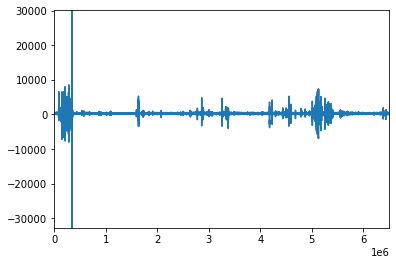

In [90]:
x_sample = bin_fp[:40000000, mic_chan_pos]
plt.plot(x_sample);

<ipython-input-84-138cc049aa2f>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Sxx[[Sxx < np.max(Sxx) * 1e-7]] = 1


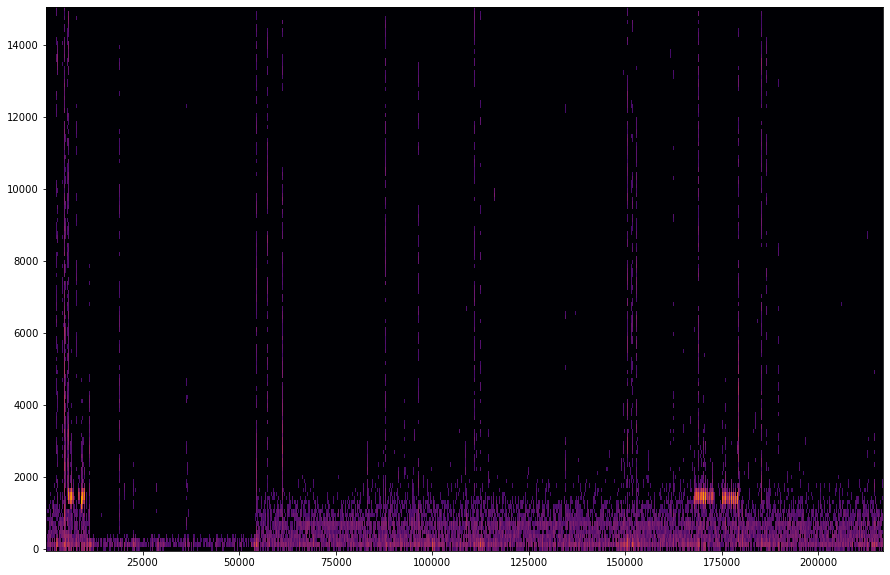

In [84]:
### Plot the spectrogram
from scipy import signal as sg
def ms_spectrogram(x, s_f, n_window=256, step_ms=1):

    # the overlap is the size of the window minus the smples in a msec
    msec_samples = int(s_f * 0.001)
    n_overlap = n_window - msec_samples * step_ms
    sigma = n_window*0.2

    # Make the spectrogram
    f, t, Sxx = sg.spectrogram(x, s_f,
                                   nperseg=n_window,
                                   noverlap=n_overlap,
                                   window=sg.gaussian(n_window, sigma),
                                   scaling='spectrum')

    Sxx[[Sxx < np.max(Sxx) * 1e-7]] = 1

    return f, t, Sxx
    

f_spec, t_spec, spec = ms_spectrogram(x_sample, s_f)

fig, ax = plt.subplots(figsize=(15, 10))

ax.pcolormesh(t_spec*1000, f_spec, np.log(spec), rasterized=True, cmap='inferno')

In [91]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/t_systest_22',
  'raw': '/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12',
  'oe': '/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/oe',
  'kwik': '/scratch/earneodo/t_systest_22/oe/kwik/2022-08-12',
  'processed': '/mnt/sphere/speech_bci/processed_data/t_systest_22/2022-08-12/oe',
  'derived': '/mnt/sphere/speech_bci/derived_data/t_systest_22/2022-08-12/oe',
  'tmp': '/scratch/earneodo/tmp',
  'msort': '/scratch/earneodo/t_systest_22/oe/msort/2022-08-12',
  'ksort': '/scratch/earneodo/t_systest_22/oe/ksort/2022-08-12/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/t_systest_22/2022-08-12/oe/sort_0'},
 'files': {'par': '/scratch/earneodo/t_systest_22/oe/ksort/2022-08-12/sort_0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/oe/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/t_systest_22/2022-08-12/oe/rig.json',
  'kwd': '/scratch/earneodo/t_systest_22/oe/kwik/2022-08-1

In [92]:
exp_struct['folders']['derived']

'/mnt/sphere/speech_bci/derived_data/t_systest_22/2022-08-12/oe'

In [96]:
rec_path = rec_list[0]
wav_file_path = os.path.join(os.path.join(os.path.join(exp_struct['folders']['derived'], 
                                                       epoch, 
                                                       os.path.split(exp_path)[-1],
                                                      os.path.split(rec_path)[-1] + '-ch_' + ch_name + '.wav')))
wav_file_path

'/mnt/sphere/speech_bci/derived_data/t_systest_22/2022-08-12/oe/2022-08-12_16-47-24/experiment1/recording1-ch_ADC1.wav'

In [98]:
os.makedirs(os.path.split(wav_file_path)[0])

chan_to_wav(continous_files_list[0], ch_name, rec_meta, wav_file_path)

2022-08-16 21:44:42,933 root         INFO     72
2022-08-16 21:44:42,935 root         INFO     64
2022-08-16 21:44:42,941 root         INFO     writing wave file /mnt/sphere/speech_bci/derived_data/t_systest_22/2022-08-12/oe/2022-08-12_16-47-24/experiment1/recording1-ch_ADC1.wav


### take a look at the neural channels

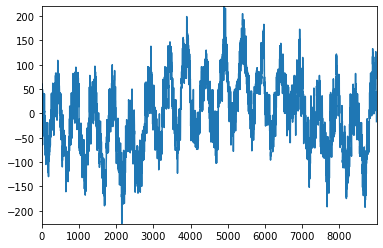

In [123]:
neur_chans = np.arange(64)
neur_sample = bin_fp[int(30000*49.7):30000*50, neur_chans]
plt.plot(neur_sample[:, 2]);

In [106]:
neur_sample.shape

(200000, 64)

ValueError: cannot convert float NaN to integer

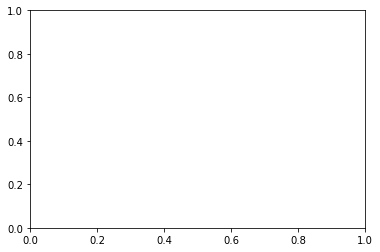

In [111]:
pu.plot_array(neur_sample.T[:,:4])

In [109]:
pu.plot_array?

Signature: pu.plot_array(x: numpy.ndarray, scale='each', ax=None, offset_scale=1) -> matplotlib.axes._axes.Axes
Docstring:
Rescale and offset an array for quick plotting multiple channels, along the 
    1 axis, for each jth axis
Arguments:
    x {np.ndarray} -- [n_col x n_row] array (each col is a chan, for instance)

Keyword Arguments:
    scale {str} -- {'each', 'max'} (default: {'each'}) whether to scale within each col
                    or to the max ptp of all cols
    ax {[type]} -- [description] (default: {None})

Returns:
    axes.Axes -- [description]
File:      /mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py
Type:      function


In [125]:
ch_name = 'CH1'

rec_path = rec_list[0]
wav_file_path = os.path.join(os.path.join(os.path.join(exp_struct['folders']['derived'], 
                                                       epoch, 
                                                       os.path.split(exp_path)[-1],
                                                      os.path.split(rec_path)[-1] + '-ch_' + ch_name + '.wav')))
wav_file_path

chan_to_wav(continous_files_list[0], ch_name, rec_meta, wav_file_path)

2022-08-16 22:00:20,265 root         INFO     72
2022-08-16 22:00:20,266 root         INFO     0
2022-08-16 22:00:20,267 root         INFO     writing wave file /mnt/sphere/speech_bci/derived_data/t_systest_22/2022-08-12/oe/2022-08-12_16-47-24/experiment1/recording1-ch_CH1.wav
